## Prediction of diabetes based on certain diagnostic measurements using Tensorflow

### Setup

In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.optimizers import SGD,Adam

### The diabetes dataset

This dataset consists of several medical predictor variables and one target variable, **Outcome** which represents if the given women has diabetes. There are 8 predictor variables which are **Number of pregnancies**,**Plasma glucose concentration** (mg dL−1),**Blood pressure** (mm Hg), **Skin thickness** (mm), **2-Hour serum insulin** (mu U/ml), **Body mass index**, **Diabetes pedigree function** and **Age**. 

Our dataset contains **768 entries** of data and our main goal is based on the given features to **classify if a given woman has diabetes or not**. 

In [2]:
dataset = pd.read_csv('diabetes.csv')

print(dataset.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [3]:
neg, pos = np.bincount(dataset['Outcome'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 768
    Positive: 268 (34.90% of total)



After analysing our data we can see that there is a big dispertion in values and scales so to facilitate training we first need to **standardize our data** as this is useful to prevent our parameters from varying over a too broad range of values.


Then we need to separate it in a **training set** (80% of data) to train our model, a **validation set** (20% of our model) to monitor how the network is classifying examples outside the training set.

In [4]:
data = dataset.to_numpy()
np.random.shuffle(data)

Y = data[:,[8]]
X = data[:,0:8]

#standardize features
means = np.mean(X,axis=0)
stds = np.std(X,axis=0)
X = (X-means)/stds

xTrain = X[:615,:]  #615‬ ~80% data
yTrain = Y[:615]

xValid = X[615:] #153 20% data
yValid = Y[615:]


### Tensorflow implementation

We start by implementing our model and initializing our weights and bias variables over the layers in our network. In this case we will start by implementing a 3 layer network a input layer with 8 neurons, one for each input feature, a 16 neuron hidden layer and an output layer consisting of one neuron as we are trying to solve a binary classification problem only one output value is needed. There is no particular method on how to decide how many neurons the hidden layers should have, so only by trying different model networks we can see which one has the best performance, but for this tutorial we will stick with this model.

Our weights will be initialized close to 0, drawn at random from a Gaussian distribution with mean zero and stdev 1/numb neurons (so that the weights dont spread out as much), to guarentee that different neurons start with different combinations of parameters. We will start with bias at 0.


In [5]:
def layer(inputs,neurons):
   weights = tf.Variable(tf.random.normal((inputs.shape[1],neurons), stddev = 1/neurons )) #initialize weights
   bias = tf.Variable(tf.zeros([neurons])) #initialize bias at 0
   return weights,bias

def create_network(X):
    network = []
    variables = []
    previous = X
 
    layers = [8,16,1] 
 
    for ix, neurons in enumerate(layers):
        weights,bias = layer(previous,neurons)
        network.append((weights,bias))
        variables.extend((weights,bias))
        previous = weights
   
    return network, variables


To finish the implementation of our model we need to choose our loss and activation functions for each layer. In this case as we are solving a binary classification problem so output neuron will have a sigmoid activation function (gives the probability of value being true: belonging to class 1), so our loss function which result we intend to minimize will be a sigmoid_cross_entropy function that receives the linear output of the network (calculated by logit function). As far as our hidden layer activation function, we could use any non-saturating function like any RELU variant to prevent the vanishing of gradients, in this case we use leaky_Relu, which also has the benifit of solving relu's problem of the neurons dying when the gradiens are very close to 0 and would no longer change.

Our grad function will be used during training to track our gradients and feed them to our optimizer of choice so that it can adjust our variables (weights and bias) in order to minimize our logistic loss.

The predict function feeds each layer's neuron activation values to the subsequent layer until it reaches the output layer where it applies the sigmoid activation to get our intended prediction value, in our case the probability of value being true: belonging to class 1.

In [6]:
def logits(X):
    net = X
    for weights, bias in network[:-1]:
        net = tf.add(tf.matmul(net, weights), bias)
        net = tf.nn.leaky_relu(net)
    weights, bias = network[-1]
    net = tf.add(tf.matmul(net, weights), bias)
    return net

def logistic_loss(logits,labels):
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    return cost

def predict(X):
    net = X
    for weights,bias  in network[:-1]:
        net = tf.add(tf.matmul(net, weights), bias)
        net = tf.nn.leaky_relu(net)
    weights,bias = network[-1]
    net = tf.add(tf.matmul(net, weights), bias)
    return tf.nn.sigmoid(net)

def grad(X, y,optimizer):
    with tf.GradientTape() as tape:
        net_out = logits(X)
        loss_val = logistic_loss(net_out,y)
    gradients = tape.gradient(loss_val, variables)
    optimizer.apply_gradients(zip(gradients, variables))


The training_stats function is a way to centralize the calculation of both the **training and validation errors**, which represent how  and far off our predictions are from the real values, and the **validation accuracy** which represents how accurate our predictions inside a given set, in this case inside our validation set (ex. 0,8 translates to 80% of values being accurately predicted)

In [7]:
def training_stats(xTrain,xValid,train_pred, yTrain, valid_pred, yValid):
    
    logits_train = logits(xTrain)
    logits_valid = logits(xValid)
    train_error = tf.reduce_mean(logistic_loss(logits_train,tf.constant(yTrain.astype(np.float32))))
    valid_error = tf.reduce_mean(logistic_loss(logits_valid,tf.constant(yValid.astype(np.float32))))
    
    correct_pred = tf.equal(tf.round(valid_pred), yValid)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return train_error,valid_error,accuracy

Now that we have our model defined we can start training it, first we just need to select and optimizer and complementary parameters. Soo to start we will use Stochastic gradient descent with a learing rate of 0.005 (determines the step size at each iteration while moving toward a minimum of a loss function. A big learing step acelarates training but might have convergence problems, while a small learning rate will improve the classification of the model at the cost of a longer training duration) , momentum 0,9, a batch size of 32 on 100 epochs (number of training cycles).

In [8]:
network, variables =create_network(xTrain)

learning_rate = 0.005
momentum = 0.9
batch_size = 32
batches_per_epoch = xTrain.shape[0]//batch_size
epochs = 100

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=momentum)

During each epoch we run through our batches, randomizing the values of the training set so that the learing pattern wont repeat themselfs, and we calculate the loss function optimizing our parameters. After we run through our batches we calculate the loss values on each the training set and on the validation set (more accurate representation of error as the data wasnt used to optimize our gradients), we also calculate the accuracy on the validation set to have a view on how well our network is predicting examples (value betweem 0 and 1 indicating how much of our values were correctly predicted beeing 1 = 100%). We repeat this proces through all epochs

In [9]:
train_errors= []
valid_errors = []
accuracy_values = []
for epoch in range(epochs):
    shuffled = np.arange(len(yTrain))
    np.random.shuffle(shuffled)
    
    for batch_num in range(batches_per_epoch):
            start = batch_num*batch_size
            batch_xs = tf.constant(xTrain[shuffled[start:start+batch_size],:].astype(np.float32))
            batch_ys = tf.constant(yTrain[shuffled[start:start+batch_size]].astype(np.float32))
            grad(batch_xs, batch_ys, optimizer)
            
    
    y_pred =predict(tf.constant(xTrain.astype(np.float32)))
    y_pred_valid =predict(tf.constant(xValid.astype(np.float32)))
   
    train_error, valid_error, accuracy = training_stats(tf.constant(xTrain.astype(np.float32)),
                                                        tf.constant(xValid.astype(np.float32)),
                                                        y_pred,
                                                        yTrain,
                                                        y_pred_valid,
                                                        yValid)
    train_errors.append(train_error)
    valid_errors.append(valid_error)
    accuracy_values.append(accuracy)
    
                    
print('loss: {}, val_loss, {}, val_acccuracy {}'.format(train_error,valid_error,accuracy))

loss: 0.36911094188690186, val_loss, 0.6141009330749512, val_acccuracy 0.7124183177947998


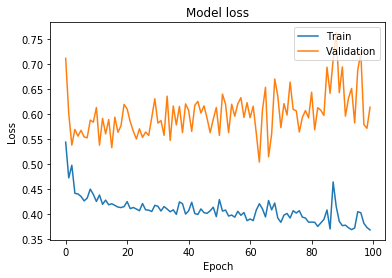

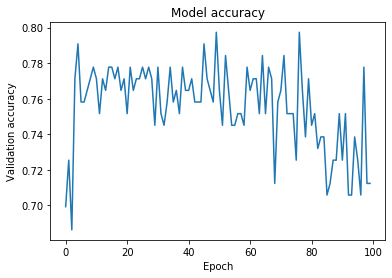

In [10]:
plt.plot(train_errors)
plt.plot(valid_errors)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')

plt.show()

Looking at the both the validation error and the training error we can identify many oscilations in values, this might suggests a problem with the traing parameters or optimizer. Another thing we can identify is that around epoch 30 to the end the validation error started to increase suggesting overfitting of our model, to solve that we can just stop training early around that epoch and in that way preventing overfitting. So to solve that let's change our optimizer to the Adam optimizer that doesn't require a learning rate value or momentum, as it combines combines several values of these parameter using an exponentially decaying average over the previous gradient. Lets also reduce the number of epochs to 25.

In [11]:
network, variables =create_network(xTrain)
batch_size = 32
batches_per_epoch = xTrain.shape[0]//batch_size
epochs = 25

optimizer = tf.keras.optimizers.Adam()

In [12]:
train_errors= []
valid_errors = []
accuracy_values = []
for epoch in range(epochs):
    shuffled = np.arange(len(yTrain))
    np.random.shuffle(shuffled)
    
    for batch_num in range(batches_per_epoch):
            start = batch_num*batch_size
            batch_xs = tf.constant(xTrain[shuffled[start:start+batch_size],:].astype(np.float32))
            batch_ys = tf.constant(yTrain[shuffled[start:start+batch_size]].astype(np.float32))
            grad(batch_xs, batch_ys, optimizer)
            
    
    y_pred =predict(tf.constant(xTrain.astype(np.float32)))
    y_pred_valid =predict(tf.constant(xValid.astype(np.float32)))
   
    train_error, valid_error, accuracy = training_stats(tf.constant(xTrain.astype(np.float32)),
                                                        tf.constant(xValid.astype(np.float32)),
                                                        y_pred,
                                                        yTrain,
                                                        y_pred_valid,
                                                        yValid)
    train_errors.append(train_error)
    valid_errors.append(valid_error)
    accuracy_values.append(accuracy)
    
                    
print('loss: {}, val_loss, {}, val_acccuracy {}'.format(train_error,valid_error,accuracy))

loss: 0.4387410879135132, val_loss, 0.5539524555206299, val_acccuracy 0.7712418437004089


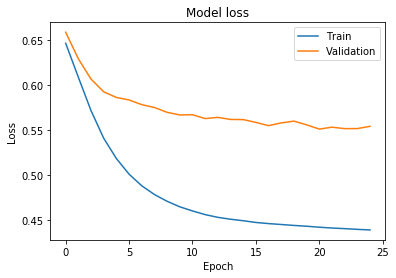

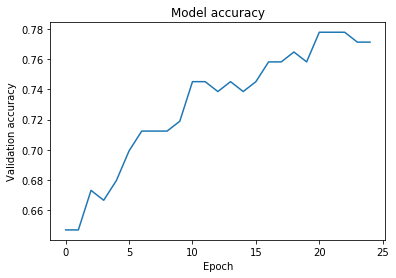

In [13]:
plt.plot(train_errors)
plt.plot(valid_errors)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')

plt.show()

As we can see this combination of parameters and optimizers gives us a more behaved set of layers with less oscilation of error values. Comparing with the previous Model we can see that the accuracy increased by 7% and the validation error decreased from (0,61 to 0,55). However if we reduce the batch size, per epoch we will have more gradient updates that would suggest a better trained model capable of better generalizing to examples outside the training set that would result in a lower validation error, so let's try with a batch size of 5. 

In [14]:
network, variables =create_network(xTrain)
batch_size = 5
batches_per_epoch = xTrain.shape[0]//batch_size
epochs = 25

optimizer = tf.keras.optimizers.Adam()

In [15]:
train_errors= []
valid_errors = []
accuracy_values = []
for epoch in range(epochs):
    shuffled = np.arange(len(yTrain))
    np.random.shuffle(shuffled)
    
    for batch_num in range(batches_per_epoch):
            start = batch_num*batch_size
            batch_xs = tf.constant(xTrain[shuffled[start:start+batch_size],:].astype(np.float32))
            batch_ys = tf.constant(yTrain[shuffled[start:start+batch_size]].astype(np.float32))
            grad(batch_xs, batch_ys, optimizer)
            
    
    y_pred =predict(tf.constant(xTrain.astype(np.float32)))
    y_pred_valid =predict(tf.constant(xValid.astype(np.float32)))
   
    train_error, valid_error, accuracy = training_stats(tf.constant(xTrain.astype(np.float32)),
                                                        tf.constant(xValid.astype(np.float32)),
                                                        y_pred,
                                                        yTrain,
                                                        y_pred_valid,
                                                        yValid)
    train_errors.append(train_error)
    valid_errors.append(valid_error)
    accuracy_values.append(accuracy)
    
                    
print('loss: {}, val_loss, {}, val_acccuracy {}'.format(train_error,valid_error,accuracy))

loss: 0.41799554228782654, val_loss, 0.565363347530365, val_acccuracy 0.7647058963775635


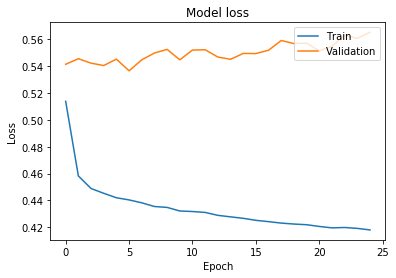

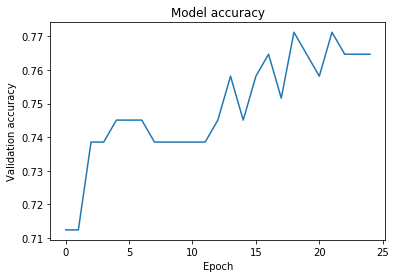

In [16]:
plt.plot(train_errors)
plt.plot(valid_errors)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')

plt.show()

We can see a slight increase in the validation error as we see that the model is starting to indicate signs of overfitting as refered previously by the increasing of the validation error arround epoch 12 so to mitigate that we would decrease the number of epochs again, until we are satisfied with the results. There are few more things that could be done to try to decrease the error such as trying different combination of layers and number of neurons or adding a dropout layer to help with regularization but the only way to know is to try them out.

## Keras API

Keras is a neural networks library that is high-level in nature making it extremely simple and intuitive to use. It works as a wrapper to low-level libraries like TensorFlow. It has two main model building API's beeing: a **functional** one that allows you to define multiple input or output models as well as models that share layers (we will not explore that in our implementation); a **sequential** one that is great for developing deep learning models in most situations, but where it's more dificult to define models that share variours layers, re-use layers or have multiple different input sources.

## Predict age of abalone from physical measurements using Keras Sequential API implementation

### Setup

In [17]:
import numpy as np;
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import SGD,Adam

### The abalone dataset

This dataset consists of several physical mesurements of Abalones (type of sea snail) in order to predict it's age given by the **Rings** feature. There are 9 predictor features which are **Sex** which takes the values of Male, Female or Infant,**length** (mm),**diameter** prependicular to length (mm), **height** (mm), **whole_weight** (grams), **shucked_weight** (grams), **viscera_weight**  (grams) and **shell_weight** (grams). 

Our dataset contains **4417 entries** of data and our main goal is based on the given features to **predict the age of the abalone**.

In [18]:
data = pd.read_csv('abalone_data.csv')

data.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


As we can see our sex parameter didint show up when we describe our data, that is because its values are strings of 3 different values and so we need to one hot encode those values to be able to use them, this will remove the original feature 'sex' and add 3 new features one for each sex (male, female and infant).

After that we need to standardize our data, including the target feature of age  as this is useful to prevent very large values resulting in convergence problems.

Then we need to separate it in a training set (70% of data) to train our model, a validation set (20% of our model) to monitor how the network is performin outside the training set, and a test set of (10% of data)tis tells us how well we can expect the model to predict when we use it in the real world.

In [19]:
ohe = pd.get_dummies(data['sex'], prefix='sex')

data = pd.concat([data, ohe], axis=1)

data= data.drop(['sex'],axis=1)

New data with one-hot-encoding

In [20]:
data.describe()


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,0.312904,0.321283,0.365813
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,0.463731,0.467025,0.481715
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


In [21]:
data = data.to_numpy()
np.random.shuffle(data)

#standardize data
means = np.mean(data,axis=0)
stds = np.std(data,axis=0)
data = (data-means)/stds


Y = data[:,[7]]
data = np.delete(data, 7, axis=1)
X = data

xTrain = X[:2924,:]  #2924‬ ~70% data
yTrain = Y[:2924]

xValid = X[2924:3758,:] #835 20% data
yValid = Y[2924:3758]

xTest = X[3758:,:] #419 10% data
yTest = Y[3758:]


Using the keras sequential API is pretty straightforward. We intend to create a model with 3 layers: 1 input layers with 10 neurons and  relu activation, 1 hidden layer with 20 neurons also with relu activation and 1 output layer with 1 neuron as we are solving a regression problem we only want the linear combination of the activation of the previous layer multiplied by the weight plus bias. For each layer we create we need to create a Dense layer, indicating the corresponding activation function in this case relu, and for the input layer we need to specify what shape of the input the model receives in our case we receice a array with lenght 10 so we define input_dim as 10.

In [22]:
def create_model_sequential():
    model = Sequential()
    model.add(Dense(10, input_dim=10, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    return model

To start defined the batch size, epoch number and optimizer as, 32, 100 and Adam optimizer respectevly. Next we need to configure our model for training, using the compile function we will use as our loss function mean square error (mse: which penalizes great deviations from the target value) as we are dealing with a regression problem, and as said our optimizer is Adam. Now we are ready for training we fit our data to our model, and therefore starting training.

In [23]:
batch_size = 32
epochs = 100

opt = Adam()

model = create_model_sequential()

model.compile(loss="mse", optimizer=opt)

history = model.fit(xTrain, yTrain, validation_data=(xValid, yValid), batch_size=batch_size, epochs=epochs, verbose=0)
print('Training mean squared error: {}'.format(history.history['loss'][-1]))
print('Validation mean squared error: {}'.format(history.history['val_loss'][-1]))

Training mean squared error: 0.39713299148059905
Validation mean squared error: 0.4527754843306484


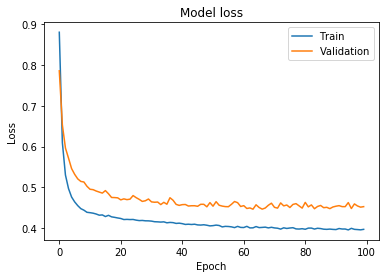

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



Now aplying the data to our test set:

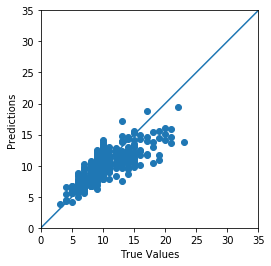

In [25]:
test_predictions = model.predict(xTest).flatten()

#reversing standardization predictions and labels to real values
t= test_predictions * stds[7]
preds = t+ means[7]
labels = yTest * stds[7]
labels = labels + means[7]


a = plt.axes(aspect='equal')
plt.scatter(labels,preds )
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 35]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

As we can see from the above graph it validades the assumption that our model generalizes our data well outside the training set with the great majority of our data being close to the predicted value (x=y). We could improve this results even further by using as an example early stopping as we saw from the error graph it maintained pretty stable for great majority of training incurring possibly in overfitting. Reducing the batch size might had also had a regularization effect improving our predictions.

## Predicting wine producer using Keras Functional API

### Setup


In [26]:
import numpy as np;
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Activation,LeakyReLU
from tensorflow.keras.optimizers import SGD,Adam

### The data

These data are the results of a chemical analysis of 178 wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

In [27]:
data = pd.read_csv('wine_dataset.csv')

data.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [28]:
print(pd.Categorical(data['Wine Type']))

[One, One, One, One, One, ..., Three, Three, Three, Three, Three]
Length: 178
Categories (3, object): [One, Three, Two]


We will need first of all to one hot encode the Wine Type attribute (classification variable) as it's value is just a string.

In [29]:
ohe = pd.get_dummies(data['Wine Type'], prefix='Wine Type')


data = pd.concat([data, ohe], axis=1)

data= data.drop(['Wine Type'],axis=1)

In [30]:
data.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Wine Type_One,Wine Type_Three,Wine Type_Two
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.331461,0.269663,0.398876
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.472066,0.445037,0.491049
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000,0.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000,0.000000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,0.000000,0.000000,0.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,1.000000,1.000000,1.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,1.000000,1.000000,1.000000


Now we standardize or feaures and separate our data into, train, validation and test sets

In [31]:
data = data.to_numpy()
np.random.shuffle(data)

#standardize our features

Y = data[:,13:]

X = data[:,:12]


#standardize data
means = np.mean(X,axis=0)
stds = np.std(X,axis=0)
data = (X-means)/stds

xTrain = X[:125,:]  #125‬ ~70% data
yTrain = Y[:125]

xValid = X[125:161,:] #36 20% data
yValid = Y[125:161]

xTest = X[161:,:] #12 10% data
yTest = Y[161:]



Building a model with the functional API of Keras is similiar to what we saw before. First define the input of the model with the Input() method describing the shape of the input(shape=(12)), next we say that it's a Dense layer with 8 neurons and receives the input, following by the declaration of it's activation function, in this case LeakyRelu activation, we stack layers until we reach the output activation layer, then we call the Model() function that takes as inputs two layers (input and output) and this model will include all layers required in the computation of output given input. This problem is a multiclass classification problem so we must need 3 neurons on the output layer (one for each class) with softmax activation. Also because we have few data on this data set, as a way of reducing the possibility of overffiting our data we will use a smaller model than usual with only one layer with 8 neurons before the output layer.

In [32]:
def create_model_functional():
    inputs =Input(shape=(12))
    layer = Dense(8)(inputs)
    layer = Activation(LeakyReLU())(layer)
    layer = Dense(3)(layer)
    layer = Activation("softmax")(layer)
    return Model(inputs=inputs, outputs=layer)

We will establish our batch size, epoch number and optimizer as 10, 50 and Adam optimizer respectevly. Next,as with the sequential API we configure our model for training, using the compile function and choose our loss function, in this case as we are intending to solve a multiclass classification problem we are going to use categorical_crossentropy which computes the categorical crossentropy loss.
We fit our data to our model, and therefore starting training.

This time we will be using early stopping using Keras API rather than testing and seeing were the error curve stagnates, we can do this by selecting which value to monitor and a number of epochs that if after that there is no significant improvement we will stop training, we will set it to 5 epochs

In [33]:
batch_size = 10
epochs = 50

opt = Adam()

model = create_model_functional()

early_stop= keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(xTrain, yTrain, validation_data=(xValid, yValid), batch_size=batch_size, epochs=epochs,verbose=0, callbacks=[early_stop])

print('Training error: {}'.format(history.history['loss'][-1]))
print('Validation error: {}'.format(history.history['val_loss'][-1]))
print('Validation Accuracy: {}'.format(history.history['val_accuracy'][-1]))

Training error: 0.5044061112403869
Validation error: 0.6038432170947393
Validation Accuracy: 0.8055555820465088


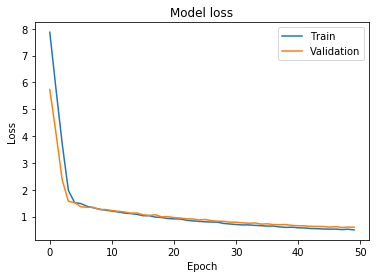

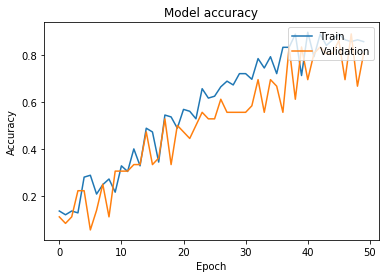

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [35]:
history = model.evaluate(xTest, yTest, batch_size=batch_size,verbose=2)

17/17 - 0s - loss: 0.5399 - accuracy: 0.8235


As we can see from the data inspite the lack of data we can still get a good accuracy rate from this model as it correctly predicted 14 examples out of 17 (~82%), something that with more data or a different combination of neurons could improve